# setup

In [1]:
# dependencies
from os.path import isdir
from pathlib import Path
import re
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# support methods
def getfiles(arg, fext):
    assert isdir(arg)
    return [path for path in Path(arg).rglob(f'*.{fext}')]


def readtext(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    return lines

In [55]:
# main
pdfs = getfiles(arg="../../scrape/output/pdfs", fext='pdf')
texts = getfiles(arg="../../pdf2text/output/txt-test/", fext='txt')
texts_ref = pd.read_parquet("../../pdf2text/output/reference-table.parquet")
segments = getfiles(arg="../../segment/output/each", fext='parquet')
segments_ref = pd.read_parquet("../../segment/output/reference-table.parquet")
#filtered = [path for path in getfiles(arg="../../filter/output", fext='parquet')
#            if 'complaints' not in path.name]
#filtered_ref = pd.read_parquet("../../filter/output/complaints.parquet")
#cleaned = pd.read_parquet("../../clean/output/complaints.parquet")
#indicated = pd.read_parquet("../../indicate/output/complaints.parquet")
#complaints = pd.read_parquet("../../export/output/complaints.parquet") # should be called allegations
#
#dpa = complaints.copy()
#working = dpa.loc[dpa.time_to_complete > pd.Timedelta(0)].copy()

In [56]:
segments_ref.shape[0]

31212

In [57]:
segments_ref.sample().T

,29291
pdf_url,https://wayback.archive-it.org/org-571/2023012...
pdf_file,output/pdfs/occ-OCC_06_05_openness.pdf
fileid,87fb9716
complaint_no,33
complaint_meta,DATE OF COMPLAINT: 08/16/04 DATE OF COMPLETION...
allegation_no,6
allegation_text,SUMMARY OF ALLEGATION #7: The officer detained...
allegation_start_page,62
continued_early,False
txt_file,../pdf2text/output/txt-test/occ-OCC_06_05_open...


In [58]:
segments_ref.loc[segments_ref.allegation_text.str.contains('continued', flags=re.I), [
    'fileid', 'complaint_no', 'allegation_no', 'allegation_text']].sample(5).values

array([['b84d9434', 29, 1,
        'SUMMARY OF ALLEGATIONS #1 - 4: The officers used unnecessary force.     CATEGORY OF CONDUCT: UF                      FINDING: PC             DEPT. ACTION:  FINDINGS OF FACT: The complainant stated the officers used unnecessary force during his detention and arrest. The complainant did not sign a medical release form. As such, the DPA was unable to obtain his medical records.  The named officers denied the allegation of unnecessary force, stating the amount of force used was reasonable and necessary to remove the complainant from the vehicle because the complainant was physically resisting them.  The first named officer stated he and his partner observed a vehicle parked in a designated disabled parking space. The vehicle did not have a disabled placard or disabled license plate displayed, which is a violation of the California Vehicle Code. When the officers approached the vehicle, the complainant was asked to roll down the window and when he did so,

In [59]:
segments_ref.loc[(
    segments_ref.fileid == 'd423c57e') & (
    segments_ref.complaint_no == 4) & (
    segments_ref.allegation_no == 2), 'allegation_text'].values

array([], dtype=object)

In [60]:
segments_ref.loc[(
    segments_ref.fileid == '2db02abb') & (
    segments_ref.complaint_no == 0) & (
    segments_ref.allegation_no == 5), ['complaint_meta', 'allegation_text']].values

array([['DATE OF COMPLAINT: 09/10/15                  DATE OF COMPLETION: 05/16/16                 PAGE #2 of 3 DATE OF COMPLAINT: 05/22/15                    DATE OF COMPLETION: 05/11/16 PAGE #3 of 3 DATE OF COMPLAINT: 09/10/15                 DATE OF COMPLETION: 05/16/16 PAGE #1 of 3 DATE OF COMPLAINT: 05/22/15                  DATE OF COMPLETION: 05/11/16                PAGE #1 of 3 DATE OF COMPLAINT: 05/22/15                  DATE OF COMPLETION: 05/11/16                  PAGE #2 of 3',
        'SUMMARY OF ALLEGATION #1: The officer detained the complainant without justification.   CATEGORY OF CONDUCT: UA                        FINDING: NS             DEPT. ACTION:  FINDINGS OF FACT: The complainant stated that, while riding his bicycle, he stopped at a red light and crossed the intersection when the light turned green. He stated that a female officer yelled at him to top at the red light, followed the complainant and stopped him a block away from the intersection. The complainant a

In [62]:
segments_ref.loc[segments_ref.fileid == '2db02abb'].allegation_text.sample(10)

11264    SUMMARY OF ALLEGATION #1: The officer behaved ...
11263    SUMMARY OF ALLEGATION #2: The officer acted in...
11237    SUMMARY OF ALLEGATION #1: The officer failed t...
11238    SUMMARY OF ALLEGATION #2: The officer failed t...
11212    SUMMARY OF ALLEGATION #1: The officer used pro...
11214    SUMMARY OF ALLEGATION #1: The officer made thr...
11259    SUMMARY OF ALLEGATION #10: The officer threate...
11186    SUMMARY OF ALLEGATION #1: The officer failed t...
11216    SUMMARY OF ALLEGATIONS #1 - 2: The officers de...
11250    SUMMARY OF ALLEGATIONS #12 - 13: The officers ...
Name: allegation_text, dtype: object

In [65]:
segments_ref.loc[segments_ref.fileid == '2db02abb'].sample(10)

,pdf_url,pdf_file,fileid,complaint_no,complaint_meta,allegation_no,allegation_text,allegation_start_page,continued_early,txt_file,blank_allegation,outside_jurisdiction,allegation_id
11199,https://wayback.archive-it.org/org-571/2023012...,output/pdfs/OCC_05_16_openness.pdf,2db02abb,6,DATE OF COMPLAINT: 06/04/15 DAT...,6,SUMMARY OF ALLEGATION #1: This complaint raise...,47,False,../pdf2text/output/txt-test/OCC_05_16_openness...,False,True,8efa8d8c550cbc29
11190,https://wayback.archive-it.org/org-571/2023012...,output/pdfs/OCC_05_16_openness.pdf,2db02abb,4,DATE OF COMPLAINT: 02/29/16 D...,1,SUMMARY OF ALLEGATION #1: The officer used unn...,40,False,../pdf2text/output/txt-test/OCC_05_16_openness...,False,False,7073b1334baf2da3
11187,https://wayback.archive-it.org/org-571/2023012...,output/pdfs/OCC_05_16_openness.pdf,2db02abb,3,DATE OF COMPLAINT: 07/08/15 D...,2,SUMMARY OF ALLEGATIONS #1-2: The officers deta...,38,False,../pdf2text/output/txt-test/OCC_05_16_openness...,False,False,c4478c3aab089fe1
11234,https://wayback.archive-it.org/org-571/2023012...,output/pdfs/OCC_05_16_openness.pdf,2db02abb,17,DATE OF COMPLAINT: 03/19/15 DAT...,1,SUMMARY OF ALLEGATIONS #1 - 2: The officers us...,73,False,../pdf2text/output/txt-test/OCC_05_16_openness...,False,False,70a9f6f2222de2be
11204,https://wayback.archive-it.org/org-571/2023012...,output/pdfs/OCC_05_16_openness.pdf,2db02abb,9,DATE OF COMPLAINT: 05/20/16 DATE O...,1,SUMMARY OF ALLEGATION #1: This complaint raise...,51,False,../pdf2text/output/txt-test/OCC_05_16_openness...,False,True,c45cbd6a20d1cbd4
11248,https://wayback.archive-it.org/org-571/2023012...,output/pdfs/OCC_05_16_openness.pdf,2db02abb,21,DATE OF COMPLAINT: 04/13/15 DAT...,6,SUMMARY OF ALLEGATION #9: The officer interfer...,81,False,../pdf2text/output/txt-test/OCC_05_16_openness...,False,False,2fd2872d5519c610
11157,https://wayback.archive-it.org/org-571/2023012...,output/pdfs/OCC_05_16_openness.pdf,2db02abb,0,DATE OF COMPLAINT: 06/04/15 D...,20,SUMMARY OF ALLEGATION #31: The officer failed ...,13,False,../pdf2text/output/txt-test/OCC_05_16_openness...,False,False,da4b0773656e340d
11207,https://wayback.archive-it.org/org-571/2023012...,output/pdfs/OCC_05_16_openness.pdf,2db02abb,10,DATE OF COMPLAINT: 04/05/16 DATE...,3,SUMMARY OF ALLEGATION #2: The officer failed t...,53,False,../pdf2text/output/txt-test/OCC_05_16_openness...,False,False,61c451fea9d607ff
11251,https://wayback.archive-it.org/org-571/2023012...,output/pdfs/OCC_05_16_openness.pdf,2db02abb,21,DATE OF COMPLAINT: 04/13/15 DAT...,9,SUMMARY OF ALLEGATIONS #14: The officer used u...,83,False,../pdf2text/output/txt-test/OCC_05_16_openness...,False,False,fcced6fbd153a60a
11227,https://wayback.archive-it.org/org-571/2023012...,output/pdfs/OCC_05_16_openness.pdf,2db02abb,15,DATE OF COMPLAINT: 04/23/15 DATE...,2,SUMMARY OF ALLEGATIONS #3-4: The officers arre...,69,False,../pdf2text/output/txt-test/OCC_05_16_openness...,False,False,c942f03d3029a603


In [30]:
segments_ref.loc[(
    segments_ref.fileid == '2db02abb') & (
    segments_ref.complaint_no == 0) & (
    segments_ref.allegation_no == 25), 'allegation_text'].values

array(['SUMMARY OF ALLEGATION #3-5: The officers failed to comply with Department General Order 9.01 and 5.08. CATEGORY OF CONDUCT: ND                         FINDING:        S        DEPT. ACTION: FINDINGS OF FACT: The complainant stated he was pulled over on a congested street when he heard a siren and saw emergency lights through his rear window. He was expecting to see a uniformed officer approach his driver side window and was startled when a man in civilian clothes walked toward him instead. The complainant did not understand that the man approaching his car was an officer until the man reached his window and held out a badge. The complainant stated plainclothes officers should not conduct traffic stops because it is alarming to see a non-uniformed person approaching your driver side window when you think you have been pulled over by a police officer. One named officer is on medical leave. The allegation against him has been bifurcated from thi Complaint Summary Report. This find

# disclaimer
### things still in progress

There are data entry, parsing, and processing errors in the Datetime data that are still being worked out. Much of this has been recovered but where `time_to_complete` is referenced, it will be from the subset of data that has a logical `time_to_complete` value (ie. not negative).

In [4]:
dpa.time_to_complete.describe()

count                          25240
mean     254 days 09:12:29.667194928
std      208 days 19:41:46.066139968
min              -608 days +00:00:00
25%                127 days 00:00:00
50%                246 days 00:00:00
75%                328 days 00:00:00
max               2805 days 00:00:00
Name: time_to_complete, dtype: object

In [5]:
working.time_to_complete.describe()

count                          25026
mean     257 days 10:31:30.194198036
std      206 days 19:17:33.832013244
min                  1 days 00:00:00
25%                130 days 00:00:00
50%                247 days 00:00:00
75%                329 days 00:00:00
max               2805 days 00:00:00
Name: time_to_complete, dtype: object

In [6]:
n_dropped = dpa.shape[0] - working.shape[0]
prop_dropped = round(n_dropped/dpa.shape[0], 3)
f"{n_dropped} rows or {prop_dropped*100:.1f}% of the data have an invalid `time_to_close`"

'301 rows or 1.2% of the data have an invalid `time_to_close`'

#### how many allegations are missing datetime info?

In [7]:
dpa.loc[dpa.year_complained.isna(), ['date_complained', 'year_complained']].shape[0]

35

In [8]:
dpa.loc[dpa.year_completed.isna(), ['date_completed', 'year_completed']].shape[0]

0

In [9]:
# report info for allegations missing date complained
# this is likely due to an extraction error we should be able to fix
# dpa.loc[dpa.year_complained.isna(), ['pdf_file', 'date_complained', 'complaint_meta']]

# about the collection

#### how many report files have been scraped?

In [10]:
len(dpa.fileid.unique())

180

#### how many complaints are represented in the collection?

In [11]:
len(dpa.complaint_id.unique())

8549

#### what is the timeline of complaints in the reports?

In [12]:
dpa.date_complained.describe()

count                            25292
mean     2012-08-20 21:24:23.798829824
min                2001-07-17 00:00:00
25%                2007-01-03 00:00:00
50%                2013-09-25 00:00:00
75%                2017-12-22 00:00:00
max                2024-01-24 00:00:00
Name: date_complained, dtype: object

#### how many allegations are represented in the collection?

In [13]:
len(dpa.allegation_id.unique())

25327

#### is the data 1 row per allegation?

In [14]:
dpa.shape[0] == len(dpa.allegation_id.unique())

True

#### how many complaints are in the average report?

In [15]:
dpa[['fileid', 'complaint_no']].groupby('fileid').complaint_no.max().mean().astype(int)

54

#### how many allegations are in the average complaint?

In [16]:
dpa[['complaint_id', 'allegation_no']].groupby('complaint_id').allegation_no.max().mean().astype(int)

3

# about the timeline

#### how many complaints are received over time?

<Axes: xlabel='year_complained'>

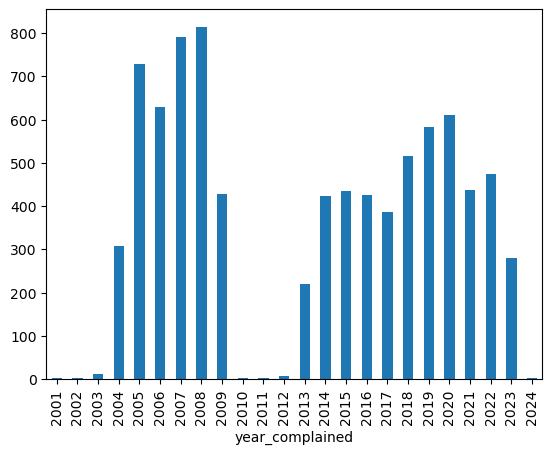

In [17]:
yearly_compls = dpa.loc[dpa.year_complained.notna(), ['year_complained', 'complaint_id']]
yearly_compls.year_complained = yearly_compls.year_complained.astype(int)
yearly_compls.groupby('year_complained').complaint_id.apply(
    lambda x: len(x.unique())).plot(kind='bar')

#### how many allegations are received over time?

<Axes: xlabel='year_complained'>

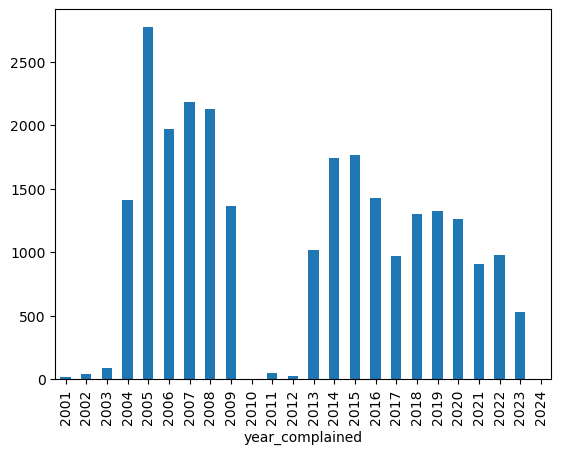

In [18]:
yearly_allegs = dpa.loc[dpa.year_complained.notna(), ['year_complained', 'allegation_id']]
yearly_allegs.year_complained = yearly_allegs.year_complained.astype(int)
yearly_allegs.groupby('year_complained').allegation_id.apply(
    lambda x: len(x.unique())).plot(kind='bar')

#### how long is the average investigation into a complaint?
- measured in days between `date_complained` and `date_completed`
- only includes allegations/rows with a non-negative `time_to_complete`
- organized by the `year_complained`

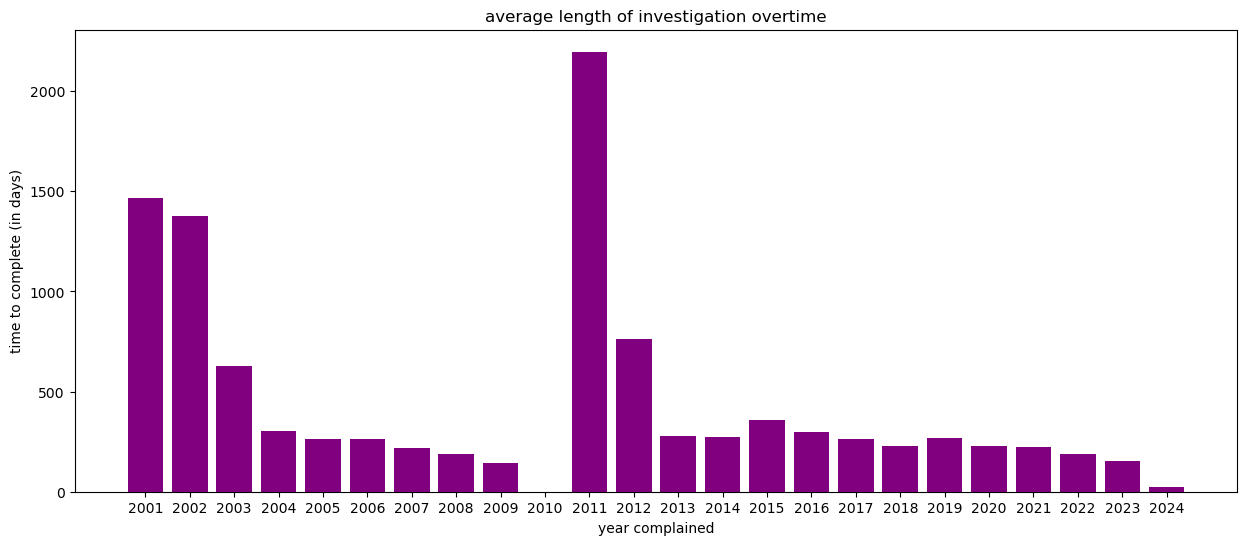

In [19]:
ttc_vc = working[['year_complained', 'time_to_complete']].groupby('year_complained').mean().sort_index().reset_index()
x = ttc_vc.year_complained.astype(int).astype(str).values
y = ttc_vc.time_to_complete.dt.days.values

fig= plt.figure(figsize=(15,6))
plt.title("average length of investigation overtime")
plt.xlabel("year complained")
plt.ylabel("time to complete (in days)")
plt.bar(x,y, label='', color='purple')
plt.show()

## about `sustained` or `mediated` allegations

#### how many allegations were sustained?

In [20]:
dpa.sustained.value_counts()

sustained
False    23679
True      1648
Name: count, dtype: int64

#### how many allegations were mediated?

In [21]:
dpa.mediated.value_counts()

mediated
False    24301
True      1026
Name: count, dtype: int64

#### are any allegations both mediated and sustained? or are these mutually exclusive?

In [22]:
(dpa.sustained & dpa.mediated).any()

False

#### what are the original `finding` codes for `sustained` allegations?

In [23]:
dpa.loc[dpa.sustained == True, 'finding_original'].value_counts()

finding_original
S                   1126
PF                   164
IC/S                 157
TF                   106
IC(S)                 28
IC                    25
IC (Sustained)        13
SF                     8
SUS                    6
IC (SUSTAINED)         4
Sustained              3
Improper Conduct       2
Policy Failure         2
SUST                   2
ICS                    1
S/IC                   1
Name: count, dtype: int64

#### what are top 5 the original `category_of_conduct` codes for `sustained` allegations?

In [24]:
dpa.loc[dpa.sustained == True, 'category_of_conduct'].value_counts().head()

category_of_conduct
Neglect of Duty                  917
Unwarranted Action               364
CRD                              200
Unnecessary Force                 60
Conduct Unbecoming an Officer     52
Name: count, dtype: int64

#### what are the top 5 original `category_of_conduct` codes for `mediated` allegations?

In [25]:
dpa.loc[dpa.mediated == True, 'category_of_conduct'].value_counts().head()

category_of_conduct
Neglect of Duty                  383
CRD                              322
Unwarranted Action               222
Conduct Unbecoming an Officer     57
Discourtesy                       24
Name: count, dtype: int64

#### what are the top 5 original `finding` codes for allegations not `sustained` or `mediated`?

In [26]:
dpa.loc[~(dpa.sustained | dpa.mediated), 'finding'].value_counts().head()

finding
NS                9968
Proper Conduct    5990
No Finding        2258
Unfounded         2180
Withdrawn          941
Name: count, dtype: int64

#### what are the rates of `mediated` and `sustained` allegations over time compared to other outcomes?

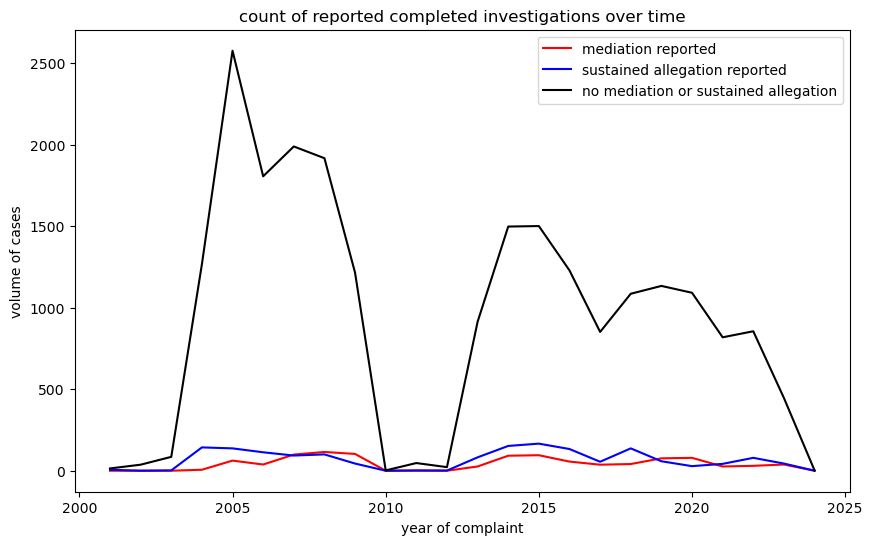

In [27]:
test = working[['year_complained', 'mediated', 'sustained']
    ].groupby('year_complained').value_counts().to_frame().reset_index()
x = sorted(test.year_complained.unique())
y = {str(int(year)):
     test.loc[(test.year_complained == year) & (test.mediated),
     'count'].sum() for year in sorted(test.year_complained.unique())
    }.values()
y2 = {str(int(year)):
     test.loc[(test.year_complained == year) & (test.sustained),
     'count'].sum() for year in sorted(test.year_complained.unique())
    }.values()
y3 = {str(int(year)):
     test.loc[(test.year_complained == year) & (~(test.mediated | test.sustained)),
     'count'].sum() for year in sorted(test.year_complained.unique())
    }.values()

fig= plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(x, y, label='mediation reported', color='red')
plt.plot(x, y2, label='sustained allegation reported', color='blue')
plt.plot(x, y3, label='no mediation or sustained allegation', color='black')
plt.title("count of reported completed investigations over time")
plt.xlabel("year of complaint")
plt.ylabel("volume of cases")
ax.legend(loc='upper right')
plt.show()

# about the allegations

#### what are the top 5 types of allegations by `category_of_conduct`?

In [28]:
dpa.category_of_conduct.value_counts().head()

category_of_conduct
Neglect of Duty                  7492
Unwarranted Action               7434
CRD                              5331
Unnecessary Force                2110
Conduct Unbecoming an Officer    1406
Name: count, dtype: int64

#### what do the indicators derived from the SUMMARY OF ALLEGATION data say about the allegation categories?

In [29]:
dpa[[
    'action_wo_cause',
    'entry_wo_cause', 'search_wo_cause', 'towed_wo_cause',
    'tookproperty_wo_cause', 'cite_wo_cause', 'detain_wo_cause',
    'arrest_wo_cause', 'display_weapon', 'unnec_force', 'dishonesty',
    'bias', 'inapp_action', 'malignant_action', 'failed_reqmt',
]].sum().sort_values(ascending=False)

failed_reqmt             7096
action_wo_cause          6269
inapp_action             6014
unnec_force              2057
detain_wo_cause          1996
malignant_action         1313
arrest_wo_cause          1185
cite_wo_cause            1124
search_wo_cause           935
bias                      757
entry_wo_cause            378
dishonesty                241
towed_wo_cause            232
tookproperty_wo_cause     192
display_weapon             55
dtype: int64

## how do the indicators compare to the DPA categories?

#### what kind of allegations are considered `Unwarranted Action` by the DPA?

In [30]:
dpa.loc[dpa.category_of_conduct == 'Unwarranted Action', 'allegations'].value_counts().head()

allegations
The officer detained the complainant without justification.     529
The officer issued a citation without cause.                    521
The officer arrested the complainant without cause.             449
The officers detained the complainant without justification.    375
The officers arrested the complainant without cause.            261
Name: count, dtype: int64

#### what kind of allegations are considered `action_wo_cause`?

In [31]:
dpa.loc[dpa.action_wo_cause, 'allegations'].value_counts().head()

allegations
The officer detained the complainant without justification.     532
The officer issued a citation without cause.                    527
The officer arrested the complainant without cause.             450
The officers detained the complainant without justification.    375
The officers arrested the complainant without cause.            262
Name: count, dtype: int64

#### what kind of allegations are considered `CRD` by the DPA?

In [32]:
dpa.loc[dpa.category_of_conduct == 'CRD', 'allegations'].value_counts().head(10)

allegations
The officer behaved inappropriately.                                       378
The officer behaved inappropriately and made inappropriate comments.       376
The officer made inappropriate comments.                                   289
The officer made an inappropriate comment.                                 127
The officer threatened the complainant.                                    119
The officer misrepresented the truth.                                      112
The officers behaved inappropriately and made inappropriate comments.       99
The officer harassed the complainant.                                       94
The officers behaved inappropriately.                                       89
The officer behaved inappropriately and/or made inappropriate comments.     88
Name: count, dtype: int64

```{note}
1. `Neglect of Duty` is similar in context and frequency to `failed_reqmt`. Our count is a bit lower likely due to a combination of:
    - the coarse nature of the regex
    - messy or noisy extractions that could be recovered with different processing
    - difference in what is counted as 'Neglect of Duty' compared to my interpretation of certain allegations
2. `Unwarranted Action` is similar in context and frequency to `action_wo_cause`.
    - It looks like we might have a gap in definitional coverage for these two, what is considered unwarranted action that I didn't pick up as an action without cause?
    - Note: `wo_cause` represents the identification of some variation of "without cause", "without justification", etc. The DPA category may include allegations that were more nuanced / less explicit than that in the content of the allegation.
3. It's unclear to me what `CRD` stands for as a category, I suspect the "C" is "Conduct", but I don't see "RD" in the codes discussed in public reporting manuals. The allegations seem to include what I count as inappropriate or malignant activity, dishonesty, and more? Unclear how this is distinct from `Conduct Unbecoming`.
    - older source: [sfpd-dgo-204-citizen-complaints-against-officers.pdf
](https://www.sanfranciscopolice.org/sites/default/files/2019-06/sfpd-dgo-204-citizen-complaints-against-officers.pdf)
    - recent source: [SFPDNotice.21026.20210329.pdf
](https://www.sanfranciscopolice.org/sites/default/files/2021-03/SFPDNotice.21026.20210329.pdf)
4. `Unnecessary Force` is very similar in context and frequency to `unnec_force`. Our count is a bit lower likely due to the same reason that (1) is off.
5. Allegations that might be labeled `Conduct Unbecoming` by the DPA are spread out into `inapp_action`, `malignant_action`, `bias`, and `dishonesty`.
6. `Discourtesy`, `Racial Slur`, and `Sexual Slur` are considered `malignant_action`.
```

#### what kind of allegations are considered `inapp_action`?
- or "inappropriate action"

In [33]:
dpa.loc[dpa.inapp_action, 'allegations'].value_counts().head()

allegations
The officer behaved or spoke inappropriately.                           452
The officer behaved inappropriately.                                    436
The officer behaved inappropriately and made inappropriate comments.    390
The officer used profanity.                                             333
The officer made inappropriate comments.                                297
Name: count, dtype: int64

#### what kind of allegations are considered `malignant_action`?

In [34]:
dpa.loc[dpa.malignant_action, 'allegations'].value_counts().head()

allegations
The officer threatened the complainant.                                     122
The officer displayed threatening, intimidating, or harassing behavior.     100
The officer harassed the complainant.                                        97
The officers displayed threatening, intimidating, or harassing behavior.     31
The officers harassed the complainant.                                       30
Name: count, dtype: int64

#### what kind of allegations are considered `dishonesty` or `bias`?

In [35]:
dpa.loc[dpa.dishonesty, 'allegations'].value_counts().head()

allegations
The officer misrepresented the truth.                       163
The officers misrepresented the truth.                       35
The officer filed false charges against the complainant.     14
The officer filed false charges.                              6
The officer misrepresented the truth                          2
Name: count, dtype: int64

In [36]:
dpa.loc[dpa.bias, 'allegations'].value_counts().head()

allegations
The officer knowingly engaged in biased policing or discrimination.    88
The officer engaged in biased policing due to race.                    78
The officer engaged in selective enforcement.                          65
The officer engaged in biased policing based on race.                  50
The officers engaged in biased policing due to race.                   41
Name: count, dtype: int64

# `liability`

In [39]:
dpa.loc[dpa.findings_of_fact.str.contains('liability', na=False)].shape[0]

31